## Analysis of KPIs

We have 10 unique KPIs in the dataset, each with a specified range. Based on the names and ranges of the KPIs, we can infer whether each KPI should ideally be maximized or minimized. Here’s a preliminary classification:

### KPI Classifications:
- **Share of teams constituted as circles** – *Maximized*  
  A higher percentage is generally considered positive.
- **Share of short-term leave** – *Minimized*  
  A lower percentage indicates fewer short-term leaves.
- **Involuntary headcount change (FTE)** – *Minimized*  
  A lower percentage indicates less involuntary turnover.
- **Reachability** – *Maximized*  
  Assuming this is a measure of communication or network reach.
- **Count sessions on .projuventute.ch** – *Maximized*  
  More sessions indicate higher website engagement.
- **Count leads** – *Maximized*  
  More leads are generally better for business.
- **Net promoter score** – *Maximized*  
  A higher score indicates better customer loyalty.
- **Private donations** – *Maximized*  
  More donations are beneficial.
- **Additional monetization/savings from CRM** – *Maximized*  
  Indicating increased efficiency or revenue.
- **Additional monetization/savings from programs** – *Maximized*  
  Indicating increased efficiency or revenue.

### Next Steps:
1. **Set Targets:**  
   Based on historical data, considering the nature of each KPI.
2. **Evaluate KPI Values:**  
   Against these targets to understand the performance.
3. **Ensure Targets are Within Range:**  
   Confirm that the set targets are within the specified KPI range to ensure they are achievable and realistic.

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

# Function to forecast the next 3 months using linear regression
def forecast_next_months(kpi_data, periods=4):
    X = np.array(range(len(kpi_data))).reshape(-1, 1)
    y = kpi_data['value'].values
    model = LinearRegression()
    model.fit(X, y)
    future_months = np.array(range(len(kpi_data), len(kpi_data) + periods)).reshape(-1, 1)
    forecasts = model.predict(future_months)
    last_date = kpi_data['date'].iloc[-1]
    future_dates = pd.date_range(start=last_date, periods=periods+1, freq='MS')[1:]
    forecast_df = pd.DataFrame({'date': future_dates, 'value': forecasts})
    return forecast_df

def create_line_plot(kpi_data, kpi_name, target_df):
    trace_actual = go.Scatter(
        x=kpi_data['date'],
        y=kpi_data['value'],
        mode='lines+markers',
        name=f'{kpi_name} Value',
        line=dict(color='blue',width=1,dash='dot')
    )
    
    forecast_df = forecast_next_months(kpi_data,4)
    trace_forecast = go.Scatter(
        x=forecast_df['date'],
        y=forecast_df['value'],
        mode='lines+markers',
        name=f'{kpi_name} Forecast',
        line=dict(color='green', dash='dot',width=1)
    )
    
    trace_target = go.Scatter(
        x=target_df['date'],
        y=target_df['target'],
        mode='lines',
        name=f'{kpi_name} Target',
        line=dict(color='red', dash='dot',width=1)
        )
    
    return [trace_actual, trace_forecast, trace_target]



# Pre-processing

In [2]:
# Load your data
df = pd.read_csv('/Users/diana/Dropbox/_hackathon/deploy_2023/_data/pj_sample_value.csv')

# Preprocessing: Creating a new date column combining period_year and period_month
df['date'] = pd.to_datetime(df['period_year'].astype(str) + '-' + df['period_month'].astype(str) + '-01', format='%Y-%m-%d')

# Sort by the new date column
df = df.sort_values(by='date')
df.drop(['period_year', 'period_month'], axis=1, inplace=True)

# clean dataset, gather classes, correct mistakes
df.dropna(inplace=True)
df.replace('0 <= X <= 100', '0 <= % <= 100', inplace=True)
df.replace('share short tern leave', 'share short term leave', inplace=True)
df.head(5)

,circle,kpi,periodicity,range,value,date
0,HR,share of teams constituted as circles,month,0 <= % <= 100,35.00,2023-01-01
12,HR,share short term leave,month,0 <= % <= 100,2.04,2023-01-01
40,Programs - Parents -Online,count sessions on .projuventute.ch,month,0 <= X,158611.00,2023-01-01
65,Fundraising,private donations,month,0 <= X,1369218.00,2023-01-01
24,HR,involuntary headcount change (FTE),month,0 <= % <= 100,2.26,2023-01-01


## Define KPI conditions:
- Trend of the target: up or down
- Set targets: a. based on historical data b. absolute targets (i.e. 0 or 100)

In [3]:
# define upward and downward trends
df['trend_target'] = 'upward'
df.loc[(df.kpi=='share short term leave')^(df.kpi=='involuntary headcount change (FTE)'),'trend_target'] = 'downward'

# Setting targets: Adjust this part according to specific needs and business logic
# Option 1: Set targets based on historical data (for example, the 75th percentile)
df['target'] = df.groupby('kpi')['value'].transform(lambda x: x.quantile(0.75))
# Option 2: Calculate the 6-month moving 75th percentile for each KPI, handling NaN values
df['target'] = df.groupby('kpi')['value'].transform(lambda x: x.rolling(window=6, min_periods=1).quantile(0.75))

# Set target for kpis with downward trend and defined range
selection = (df.trend_target=='downward')&(df.range=='0 <= % <= 100')
# Option 1: Set target to 0
df.loc[selection,'target'] = 0 # set target to 0
# Option 2: Set target to 25th percentile
df.loc[selection,'target'] = df.groupby('kpi')['value'].transform(lambda x: x.rolling(window=6, min_periods=1).quantile(0.25)).loc[selection]

# # Applying MinMax scaler to each KPI's values
df['value_norm'] = df.groupby('kpi')['value'].transform(
    lambda x: MinMaxScaler(feature_range=(0, 100)).fit_transform(x.values.reshape(-1, 1)).flatten()
    if np.count_nonzero(~np.isnan(x)) > 0 else x)
df['target_norm'] = df.groupby('kpi')['target'].transform(
    lambda x: MinMaxScaler(feature_range=(0, 100)).fit_transform(x.values.reshape(-1, 1)).flatten()
    if np.count_nonzero(~np.isnan(x)) > 0 else x)

# Difference between target and value
df['delta_norm'] = (df['value_norm'] - df['target_norm'])
df['delta_mean'] = df.groupby('kpi')['delta_norm'].transform(lambda x: x.mean())

df.head(10)

,circle,kpi,periodicity,range,value,date,trend_target,target,value_norm,target_norm,delta_norm,delta_mean
0,HR,share of teams constituted as circles,month,0 <= % <= 100,35.00,2023-01-01,upward,35.00,0.000000,0.000000,0.000000e+00,5.973193
12,HR,share short term leave,month,0 <= % <= 100,2.04,2023-01-01,downward,2.04,46.835443,0.000000,4.683544e+01,-4.904104
40,Programs - Parents -Online,count sessions on .projuventute.ch,month,0 <= X,158611.00,2023-01-01,upward,158611.00,0.000000,0.000000,0.000000e+00,-29.114078
65,Fundraising,private donations,month,0 <= X,1369218.00,2023-01-01,upward,1369218.00,25.701673,0.000000,2.570167e+01,-28.866233
24,HR,involuntary headcount change (FTE),month,0 <= % <= 100,2.26,2023-01-01,downward,2.26,100.000000,100.000000,1.421085e-14,3.934124
25,HR,involuntary headcount change (FTE),month,0 <= % <= 100,0.98,2023-02-01,downward,1.30,43.362832,54.982415,-1.161958e+01,3.934124
41,Programs - Parents -Online,count sessions on .projuventute.ch,month,0 <= X,203755.00,2023-02-01,upward,192469.00,100.000000,87.836769,1.216323e+01,-29.114078
1,HR,share of teams constituted as circles,month,0 <= % <= 100,50.00,2023-02-01,upward,46.25,27.272727,23.076923,4.195804e+00,5.973193
13,HR,share short term leave,month,0 <= % <= 100,2.20,2023-02-01,downward,2.08,53.586498,29.090909,2.449559e+01,-4.904104
66,Fundraising,private donations,month,0 <= X,2144446.00,2023-02-01,upward,1950639.00,100.000000,87.439290,1.256071e+01,-28.866233


In [8]:
# forecast with linear regression
kpi = 'share short term leave'
kpi_df = df[df['kpi'] == kpi].dropna(subset=['value'])[['date','value']].reset_index(drop=True)

forecast_df = forecast_next_months(kpi_df,3)
# add the last actual data point to plot continuosly
forecast_df = pd.concat([pd.DataFrame(kpi_df.iloc[-1,:]).T,forecast_df],ignore_index=True)

kpi_df['status'] = 'actual'
forecast_df['status'] = 'predicted'

# plot_df = pd.concat([kpi_df, forecast_df],ignore_index=True)
# target_df = df.loc[df.kpi==kpi,['date','target']]
# traces = create_line_plot(kpi_df, kpi, target_df)

# Determining the grid size for the subplots
num_kpis = len(df['kpi'].unique())
cols = int(np.ceil(np.sqrt(num_kpis)))
rows = int(np.ceil(num_kpis / cols))

# Create subplots in a grid
fig = make_subplots(rows=rows, cols=cols, 
                    subplot_titles=df['kpi'].unique(), 
                    shared_xaxes=False, shared_yaxes=False)

# Adding traces for each KPI
for index, kpi in enumerate(df['kpi'].unique()):
    kpi_df = df[df['kpi'] == kpi].dropna(subset=['value'])
    target_df = df.loc[df.kpi==kpi,['date','target']]#.rename(columns={'moving_percentile_75':'target'}) # or target
    traces = create_line_plot(kpi_df, kpi, target_df)
    
    row = int(index / cols) + 1
    col = (index % cols) + 1
    
    for trace in traces:
        fig.add_trace(trace, row=row, col=col)

# Updating layout and reducing the font size of subplot titles
fig.update_layout(height=300*rows, 
                  title_text="KPIs with Targets and Forecasts", 
                  showlegend=False,
                  # subplot_titles=[{'text': title, 'font': {'size': 10}} for title in df['kpi'].unique()]
                  )
fig.update_xaxes(tickangle=45, tickfont=dict(size=8))
fig.update_yaxes(tickfont=dict(size=8))
fig.update_annotations(font=dict(family="Helvetica", size=12))

# Show plot
fig.show()

array([[<AxesSubplot:title={'center':'value_norm'}>,
        <AxesSubplot:title={'center':'target_norm'}>],
       [<AxesSubplot:title={'center':'delta_norm'}>,
        <AxesSubplot:title={'center':'delta_mean'}>]], dtype=object)

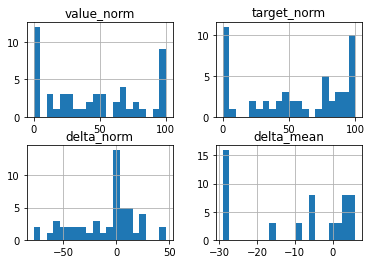

In [315]:
df.loc[:,['value_norm','target_norm','delta_norm','delta_mean']].hist(bins=20)

In [317]:
x = list(df.date.unique())[:8]
kpis = list(df.kpi.unique())

colors = ['rgb(184, 247, 212)', 'rgb(111, 231, 219)', 'rgb(127, 166, 238)', 'rgb(131, 90, 241)',
          'rgb(104, 247, 212)', 'rgb(101, 231, 219)', 'rgb(107, 166, 238)', 'rgb(101, 90, 241)']

fig = go.Figure()

for i,k in enumerate(kpis):
    y=list(df[df.kpi==k].sort_values(by='date')['delta_norm'])
    if len(y)==len(x):
        fig.add_trace(go.Scatter(
            x=x,
            y=y,
            mode='lines',
            line=dict(width=0.5, color=colors[i]),
            stackgroup='one',
            groupnorm='percent' # sets the normalization for the sum of the stackgroup
            ))
    else:
        pass

fig.update_layout(
    showlegend=True,
    xaxis_type='category',
    yaxis=dict(
        type='linear',
        range=[1, 100],
        ticksuffix='%'))

fig.show()

In [318]:
fig = px.area(df, x="date", y="delta_norm", color="kpi")
fig.show()